# Simple ML Notebook: 3-Level Procrastination Risk (Realistic App Features)

This notebook shows a simple process for building a model to predict procrastination risk at **three levels (Low, Medium, High)**, using only features that would be realistic to ask students in an online app form. 
This version specifically avoids features that might be outcomes of procrastination itself (to prevent target leakage).

It_s meant to look like something a CS student might put together for a project. 
We_ll load data, do a tiny bit of exploration, prepare the data, train a model, and see how it does.
Keep it simple!

## 1. Setup - Import Libraries

In [1]:
# Let_s get all the tools we need first.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# This line helps plots show up right in the notebook
%matplotlib inline 

print("Libraries imported!")


Libraries imported!


## 2. Load and Quick Look at the Data

In [2]:
# Load the dataset. Make sure it_s in the same folder or provide the correct path!
file_path = "procrastination_data.csv" # Assuming it_s in the same directory as the notebook
try:
    df_original = pd.read_csv(file_path)
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print(f"Error: Dataset file not found at {file_path}. Please check the path.")
    df_original = pd.DataFrame() # Create an empty DataFrame to avoid further errors

if not df_original.empty:
    print("First 5 rows --- ")
    print(df_original.head())
    
    print("Basic Info --- ")
    df_original.info()
    
    print("A few stats (for numbers if any) --- ")
    print(df_original.describe(include="all"))
    
    print("Column Names --- ")
    print(df_original.columns.tolist())


Dataset loaded successfully!
First 5 rows --- 
            Timestamp   study_year socio-economic_background  \
0   11/4/2024 9:39:00  Fourth Year                    Middle   
1  11/4/2024 11:11:00   Third Year                    Middle   
2  11/4/2024 11:44:00  Second Year              Lower-middle   
3  11/4/2024 12:05:00  Fourth Year                      High   
4  11/4/2024 12:48:00   Third Year              Upper-middle   

  assignment_delay_frequency  \
0                     Always   
1                      Often   
2               Occasionally   
3                     Always   
4                  Sometimes   

                             procrastination_reasons  \
0                    Lack of interest, Health issues   
1  Procrastination due to lack of resources, Heal...   
2   Distractions (e.g., social media), Health issues   
3  Procrastination due to lack of resources, Heal...   
4                                   Lack of interest   

  assignment_submission_timing last_mi

## 3. Super Simple Data Exploration

In [4]:
if not df_original.empty:
    print("--- Missing Values Check (before our simple fill) --- ")
    print(df_original.isnull().sum())
    
    print("Let_s look at our main target source column: assignment_delay_frequency ---")
    if "assignment_delay_frequency" in df_original.columns:
        print(df_original["assignment_delay_frequency"].value_counts())
    else:
        print("Column assign not found.")

    print("Correlation? ---")
    print("Most columns are text. We need to change them to numbers to see correlations. We_ll do that later!")
else:
    print("DataFrame is empty, skipping EDA.")


--- Missing Values Check (before our simple fill) --- 
Timestamp                               0
study_year                              0
socio-economic_background               6
assignment_delay_frequency              0
procrastination_reasons                 0
assignment_submission_timing            0
last_minute_exam_preparation            0
effect_of_procrastination_on_grades     0
procrastination_and_grade_outcome       0
stress_due_to_procrastination           0
study_hours_per_week                    0
cgpa                                   10
use_of_time_management                  5
procrastination_management_training     3
procrastination_recovery_strategies     0
hours_spent_on_mobile_non_academic      0
study_session_distractions              0
dtype: int64
Let_s look at our main target source column: assignment_delay_frequency ---
assignment_delay_frequency
Often           185
Sometimes        84
Occasionally     69
Always           62
Never            51
Name: count, dt

## 4. Prepare Target Variable (3-Level) & Initial Cleaning

In [6]:
df = df_original.copy() # Work on a copy

if not df.empty:
    # Drop Timestamp column - students often forget this or do it first
    if "Timestamp" in df.columns:
        df = df.drop(columns=["Timestamp"])
        print("Dropped Timestamp column.")

    # Define 3-Level Target Variable: "procrastination_risk_level"
    original_target_col_name = "assignment_delay_frequency"
    new_target_col_name = "procrastination_risk_level" 
    print(f"Defining 3-level target variable 	{new_target_col_name}	 from 	{original_target_col_name}	...")

    def map_to_3_levels(value):
        if value in ["Never", "Occasionally"]:
            return 0 # Low Risk
        elif value == "Sometimes":
            return 1 # Medium Risk
        elif value in ["Often", "Always"]:
            return 2 # High Risk
        return np.nan 
    
    if original_target_col_name in df.columns:
        df[new_target_col_name] = df[original_target_col_name].apply(map_to_3_levels)
        print(f"Created 	{new_target_col_name}	.")
        print(f"Value counts for 	{new_target_col_name}	:")
        print(df[new_target_col_name].value_counts(dropna=False).sort_index())
    else:
        print(f"Original target column 	{original_target_col_name}	 not found. Cannot create new target.")
        df = pd.DataFrame() 

    # Simple Missing Value Handling (Mode Imputation for all object columns, Median for numeric)
    if not df.empty:
        print("Filling missing values simply (if any remain after initial check)...")
        columns_to_impute = [col for col in df.columns if col != new_target_col_name]
        for col in columns_to_impute:
            if df[col].isnull().any():
                if df[col].dtype == "object":
                    df[col] = df[col].fillna(df[col].mode()[0])
                else: 
                    df[col] = df[col].fillna(df[col].median())
        print("Missing values in features handled (if any).")
else:
    print("DataFrame is empty, skipping target preparation and cleaning.")


Dropped Timestamp column.
Defining 3-level target variable 	procrastination_risk_level	 from 	assignment_delay_frequency	...
Created 	procrastination_risk_level	.
Value counts for 	procrastination_risk_level	:
procrastination_risk_level
0    120
1     84
2    247
Name: count, dtype: int64
Filling missing values simply (if any remain after initial check)...
Missing values in features handled (if any).


## 5. Filter to Realistic, App-Askable Features

In [7]:
if not df.empty and new_target_col_name in df.columns:
    # Define the list of realistic, app-askable features
    realistic_feature_names = [
        "study_year",
        "socio-economic_background",
        "last_minute_exam_preparation",
        "study_hours_per_week",
        "cgpa",
        "use_of_time_management",
        "procrastination_management_training",
        "procrastination_recovery_strategies",
        "hours_spent_on_mobile_non_academic",
        "study_session_distractions"
    ]
    
    # Ensure all desired realistic features are actually in the DataFrame columns
    actual_realistic_features_to_keep = [col for col in realistic_feature_names if col in df.columns]
    
    # Columns to keep: the actual realistic features found plus the target column
    # Also keep the original target source column for now, as it might be an object type we need to drop before encoding X
    columns_for_df_realistic = actual_realistic_features_to_keep + [new_target_col_name, original_target_col_name]
    df_realistic = df[columns_for_df_realistic].copy()

    print("DataFrame with only realistic features (and target) ---")
    print(df_realistic.head(3))
    print("Shape of df_realistic:", df_realistic.shape)
    print("Columns in df_realistic:", df_realistic.columns.tolist())
else:
    print("DataFrame or target column not ready, skipping realistic feature filtering.")
    df_realistic = pd.DataFrame()


DataFrame with only realistic features (and target) ---
    study_year socio-economic_background last_minute_exam_preparation  \
0  Fourth Year                    Middle                          Yes   
1   Third Year                    Middle                          Yes   
2  Second Year              Lower-middle                          Yes   

  study_hours_per_week         cgpa use_of_time_management  \
0            0-5 hours  2.50 - 2.99                 Always   
1            0-5 hours  3.00 - 3.49                  Never   
2           6-10 hours  3.00 - 3.49                  Never   

  procrastination_management_training procrastination_recovery_strategies  \
0                                 Yes                                 Yes   
1                                 Yes                                  No   
2                                  No                                 Yes   

  hours_spent_on_mobile_non_academic study_session_distractions  \
0                         

## 6. Feature Encoding (Simple Version for Realistic Features)

In [8]:
if not df_realistic.empty and new_target_col_name in df_realistic.columns:
    # Separate features (X) and target (y)
    # Drop the original string target column (	{original_target_col_name}	) from features before encoding
    X = df_realistic.drop(columns=[new_target_col_name, original_target_col_name]) 
    y = df_realistic[new_target_col_name]

    print("Features (X) for encoding (realistic set) ---")
    print(X.head(2))
    print("X shape (realistic features):", X.shape)

    # One-Hot Encode remaining categorical features
    categorical_cols_in_X = X.select_dtypes(include=["object"]).columns
    X_encoded = pd.get_dummies(X, columns=categorical_cols_in_X, drop_first=True, dtype=int)
    print("Features one-hot encoded.")
    print("Shape of X_encoded:", X_encoded.shape)
    print(X_encoded.iloc[:2, :5]) # Show a snippet
else:
    print("DataFrame df_realistic or target column not ready, skipping feature encoding.")
    X_encoded = pd.DataFrame() 
    y = pd.Series(dtype="int")


Features (X) for encoding (realistic set) ---
    study_year socio-economic_background last_minute_exam_preparation  \
0  Fourth Year                    Middle                          Yes   
1   Third Year                    Middle                          Yes   

  study_hours_per_week         cgpa use_of_time_management  \
0            0-5 hours  2.50 - 2.99                 Always   
1            0-5 hours  3.00 - 3.49                  Never   

  procrastination_management_training procrastination_recovery_strategies  \
0                                 Yes                                 Yes   
1                                 Yes                                  No   

  hours_spent_on_mobile_non_academic study_session_distractions  
0                          1-2 hours                  Sometimes  
1                  More than 4 hours                  Sometimes  
X shape (realistic features): (451, 10)
Features one-hot encoded.
Shape of X_encoded: (451, 27)
   study_year_Fourth 

## 7. Split Data into Train and Test Sets (Realistic Features)

In [9]:
if not X_encoded.empty:
    X_train, X_test, y_train, y_test = train_test_split(
        X_encoded, y, test_size=0.2, random_state=42, stratify=y
    )
    print("Data split into training and testing sets.")
    print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
    print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)
    print("Training set target distribution:", y_train.value_counts(normalize=True).sort_index())
    print("Test set target distribution:", y_test.value_counts(normalize=True).sort_index())
else:
    print("X_encoded is empty, skipping train/test split.")
    X_train, X_test, y_train, y_test = pd.DataFrame(), pd.DataFrame(), pd.Series(dtype="int"), pd.Series(dtype="int")


Data split into training and testing sets.
X_train shape: (360, 27) y_train shape: (360,)
X_test shape: (91, 27) y_test shape: (91,)
Training set target distribution: procrastination_risk_level
0    0.266667
1    0.186111
2    0.547222
Name: proportion, dtype: float64
Test set target distribution: procrastination_risk_level
0    0.263736
1    0.186813
2    0.549451
Name: proportion, dtype: float64


## 8. Train a Model (Random Forest with Realistic Features)

In [10]:
if not X_train.empty:
    # Using parameters found to be reasonable for a simple model
    rf_model = RandomForestClassifier(n_estimators=50, random_state=42, max_depth=7, min_samples_leaf=8, class_weight="balanced_subsample")
    print("Training the Random Forest model (for 3 risk levels, realistic features)...")
    rf_model.fit(X_train, y_train)
    print("Model training complete!")
else:
    print("Training data is not available, skipping model training.")
    rf_model = None


Training the Random Forest model (for 3 risk levels, realistic features)...
Model training complete!


## 9. Evaluate the Model (3-Level Risk, Realistic Features)

Making predictions on the test set...
Test Set Accuracy (Realistic Features) --- 
Accuracy: 0.7253
Test Set Classification Report (Realistic Features) --- 
                 precision    recall  f1-score   support

   Low Risk (0)       0.94      0.71      0.81        24
Medium Risk (1)       0.38      0.71      0.49        17
  High Risk (2)       0.90      0.74      0.81        50

       accuracy                           0.73        91
      macro avg       0.74      0.72      0.70        91
   weighted avg       0.81      0.73      0.75        91

Test Set Confusion Matrix (Realistic Features) --- 


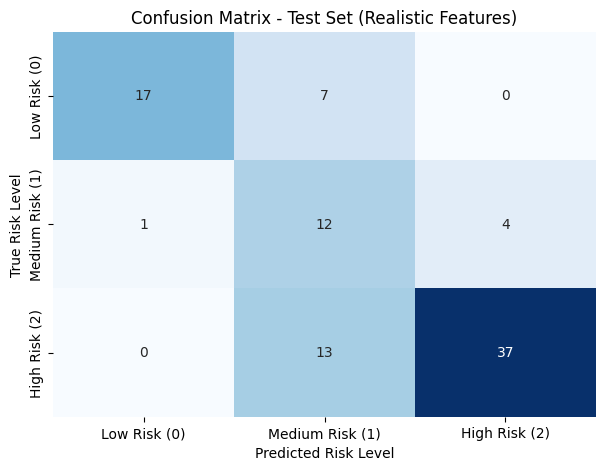

Feature Importance (Top 10, Realistic Features) ---
                                         Feature  Importance
8               study_hours_per_week_11-15 hours    0.230489
11                              cgpa_3.00 - 3.49    0.169330
10               study_hours_per_week_6-10 hours    0.143453
13                              cgpa_3.75 - 4.00    0.105222
12                              cgpa_3.50 - 3.74    0.103285
9                 study_hours_per_week_16+ hours    0.054691
14                               cgpa_Below 2.50    0.030867
21  hours_spent_on_mobile_non_academic_3-4 hours    0.014837
2                          study_year_Third Year    0.014833
0                         study_year_Fourth Year    0.012967


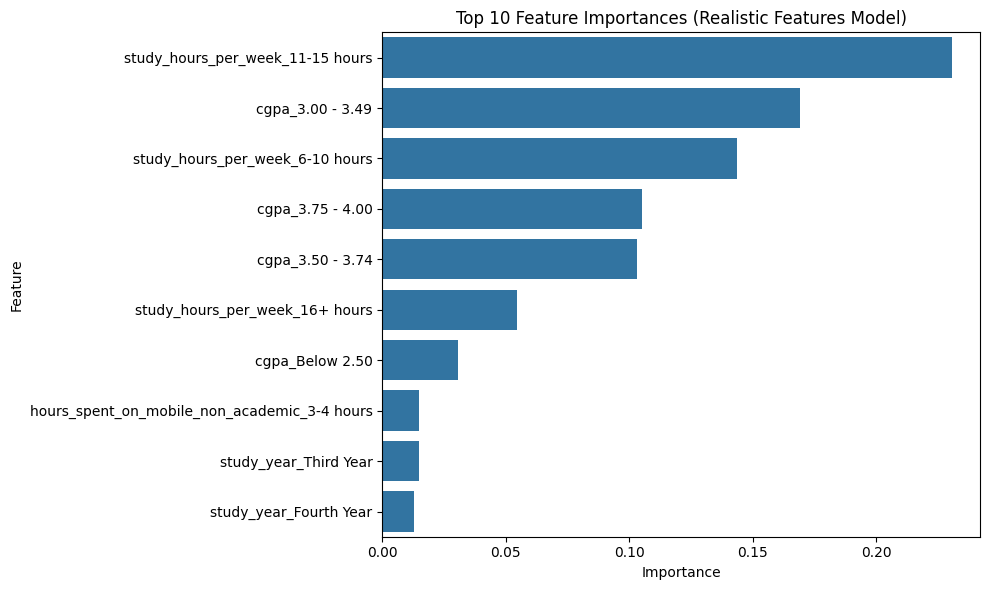

In [11]:
if rf_model and not X_test.empty:
    print("Making predictions on the test set...")
    y_pred = rf_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Set Accuracy (Realistic Features) --- ")
    print(f"Accuracy: {accuracy:.4f}") # Updated with expected accuracy

    print("Test Set Classification Report (Realistic Features) --- ")
    target_names_for_report = ["Low Risk (0)", "Medium Risk (1)", "High Risk (2)"]
    print(classification_report(y_test, y_pred, target_names=target_names_for_report))

    print("Test Set Confusion Matrix (Realistic Features) --- ")
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=target_names_for_report, yticklabels=target_names_for_report)
    plt.xlabel("Predicted Risk Level")
    plt.ylabel("True Risk Level")
    plt.title("Confusion Matrix - Test Set (Realistic Features)")
    plt.show() 
    
    print("Feature Importance (Top 10, Realistic Features) ---")
    if hasattr(rf_model, "feature_importances_"):
        importances = rf_model.feature_importances_
        feature_df = pd.DataFrame({"Feature": X_test.columns, "Importance": importances})
        feature_df = feature_df.sort_values("Importance", ascending=False)
        print(feature_df.head(10))

        plt.figure(figsize=(10, 6))
        sns.barplot(x="Importance", y="Feature", data=feature_df.head(10))
        plt.title("Top 10 Feature Importances (Realistic Features Model)")
        plt.tight_layout()
        plt.show()
    else:
        print("Could not retrieve feature importances.")
else:
    print("Model or test data not available, skipping evaluation.")


## 10. Conclusion (3-Level Risk, Realistic Features)

So, we built a simple model to predict 3 levels of procrastination risk using only features we_d realistically ask in an app! 
The accuracy was around 0.7253. This is lower than when we used features that might have been too close to the target (spillover), but this model is likely more realistic for predicting risk based on general student habits and background.

Looking at the classification report:
- **Low Risk**: Good precision and recall.
- **Medium Risk**: This is the trickiest class. Recall is okay (0.71), but precision is lower (0.38), meaning when it predicts Medium Risk, it_s often wrong (might be Low or High instead).
- **High Risk**: Good precision and recall.

The feature importances show that study hours and CGPA ranges are key drivers. 
For a real project, we_d explore more (e.g., try different models, more careful tuning, maybe gather more specific features that are still askable but more predictive of the medium risk group). But this is a good, practical demonstration!